# 1. SYSTEM & LIBRARY IMPORTS

In [1]:
!pip install tensorflow tensorflow-datasets
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-9zcy4mdo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-9zcy4mdo
  Resolved https://github.com/tensorflow/examples.git to commit b5a8265e0b655001eaa859e7bd8ac9b4e03f3ce8
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1763062947.1037077196981023548712530743058318120274395872488-py3-none-any.whl size=300320 sha256=364925c839ec80e47860dec53bbc3c3280ddb10f0b8e2f1cc83feb8bd9734af6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4z8r5o4z/wheels/ab/17/30/d16d07e2c95286770a9ddcd6f41629ea92b998858c5ee235aa
Successfully built tensorflow-examples


In [2]:
import numpy as np
import tensorflow as tf

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 2.0.2
TensorFlow version: 2.19.0


In [3]:
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
import matplotlib.pyplot as plt

print(f"Python version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow version: 2.19.0


# 2. DATASET LOADING


In [5]:
tfds.disable_progress_bar()
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

IMG_SIZE = 128
OUTPUT_CHANNELS = 3
BATCH_SIZE = 64
BUFFER_SIZE = 1000

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


# 3. DATA PREPROCESSING WITH AUGMENTATION

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Data augmentations
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_brightness(input_image, 0.2)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_contrast(input_image, 0.8, 1.2)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_hue(input_image, 0.05)

    return normalize(input_image, input_mask)

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    return normalize(input_image, input_mask)

# 4. DATASET PIPELINE


In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# 5. VISUALIZATION


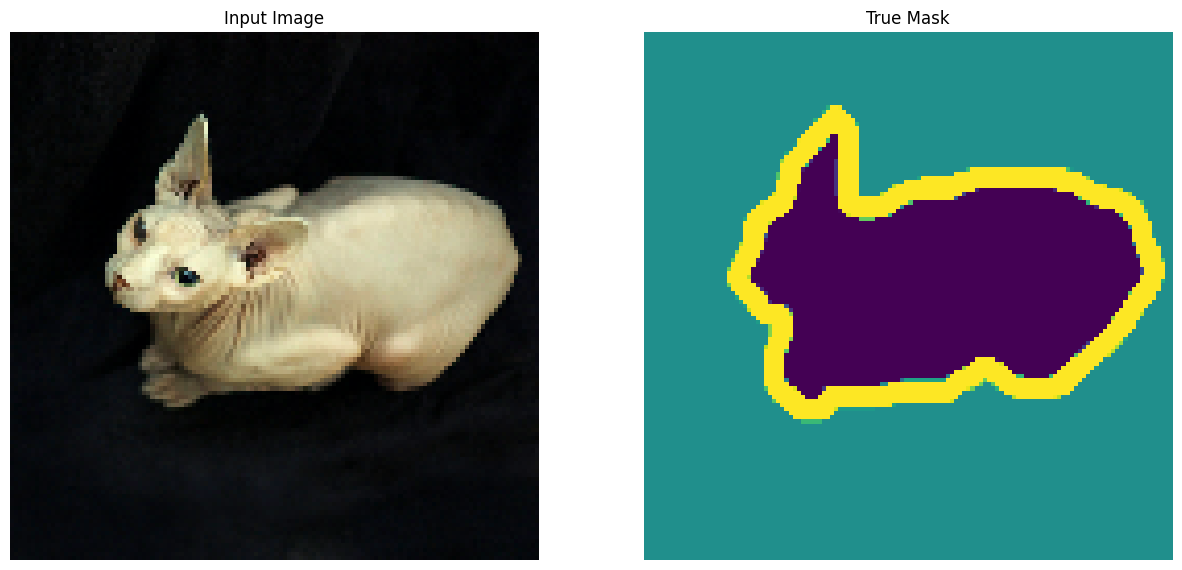

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Test display
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# 6. U-NET MODEL WITH MobileNetV2 BACKBONE


In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False  # Stage 1: freeze backbone

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = inputs
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 7. COMBINED LOSS FUNCTION (Dice + Categorical Crossentropy)


In [14]:
def dice_loss(y_true, y_pred):
    # Cast labels to int32 for one_hot
    y_true = tf.cast(y_true, tf.int32)

    # Remove channel dimension if needed
    y_true_squeezed = tf.squeeze(y_true, axis=-1)

    # One-hot encode
    y_true_onehot = tf.one_hot(y_true_squeezed, OUTPUT_CHANNELS)

    # Apply softmax to predictions
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true_onehot * y_pred)
    union = tf.reduce_sum(y_true_onehot) + tf.reduce_sum(y_pred)

    return 1 - (2. * intersection + 1e-6) / (union + 1e-6)


def combined_loss(y_true, y_pred):
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred) + dice_loss(y_true, y_pred)

# 8. CALLBACKS


In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 9. MASK PREDICTION FUNCTION


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


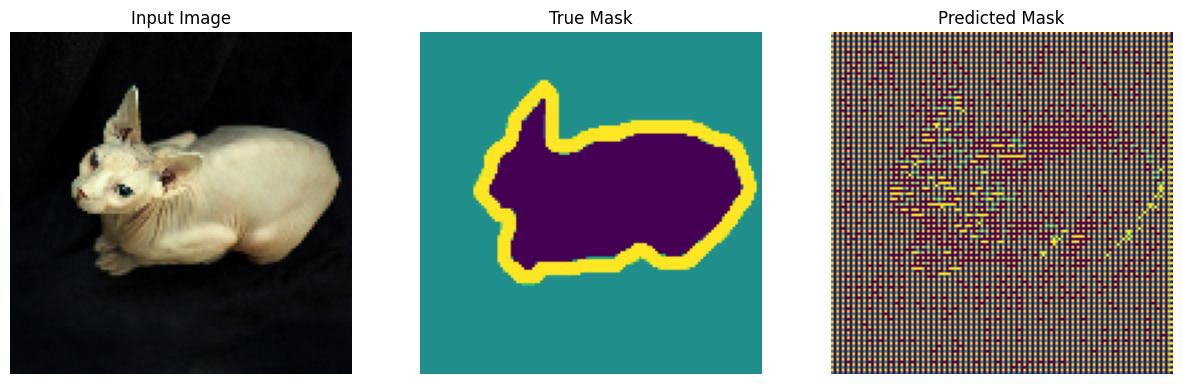

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

# 10. TRAINING STAGE 1: TOP LAYERS ONLY


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


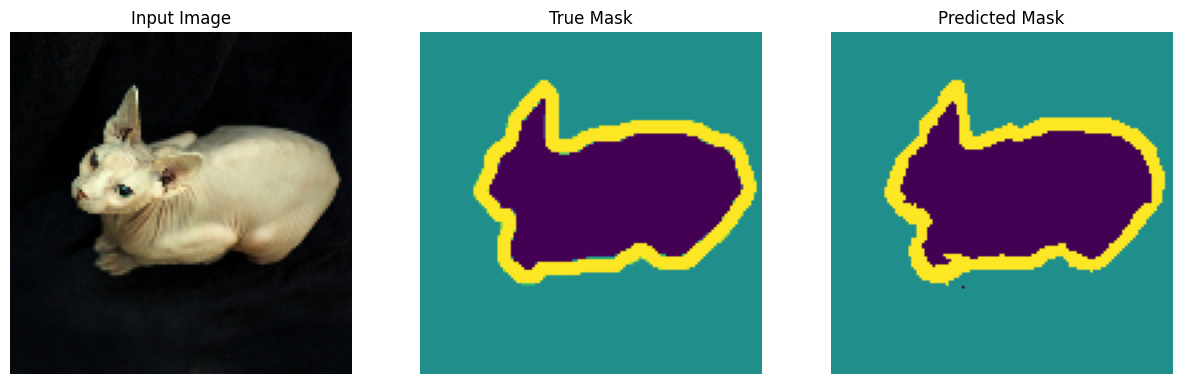


Sample Prediction after epoch 17

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9352 - loss: 0.2230 - val_accuracy: 0.8926 - val_loss: 0.4277 - learning_rate: 5.0000e-04


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=combined_loss,
              metrics=['accuracy'])

EPOCHS_STAGE1 = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history_stage1 = model.fit(train_dataset,
                           epochs=EPOCHS_STAGE1,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_steps=VALIDATION_STEPS,
                           validation_data=test_dataset,
                           callbacks=[DisplayCallback(), early_stop, reduce_lr])

# 11. TRAINING STAGE 2: FINE-TUNE BACKBONE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


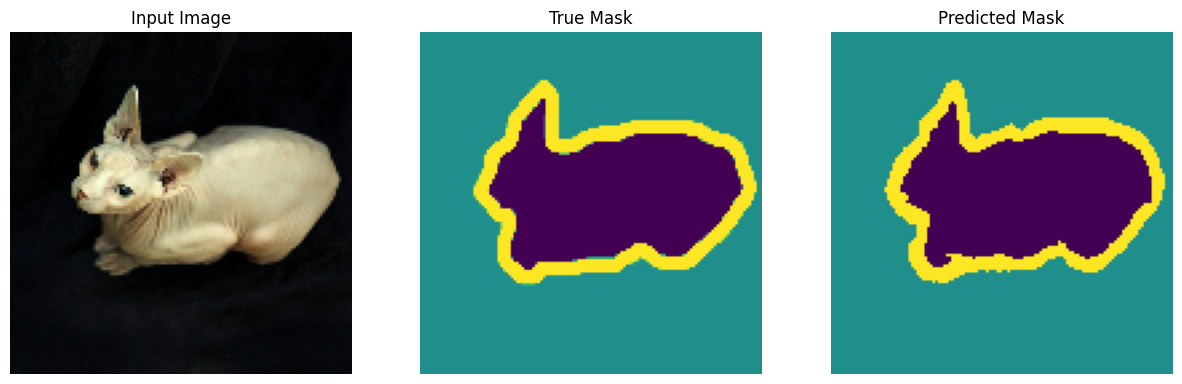


Sample Prediction after epoch 8

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9362 - loss: 0.2179 - val_accuracy: 0.8913 - val_loss: 0.4338 - learning_rate: 5.0000e-05


In [18]:
down_stack.trainable = True
for layer in down_stack.layers[:-20]:  # unfreeze last 20 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=combined_loss,
              metrics=['accuracy'])

EPOCHS_STAGE2 = 20
history_stage2 = model.fit(train_dataset,
                           epochs=EPOCHS_STAGE2,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_steps=VALIDATION_STEPS,
                           validation_data=test_dataset,
                           callbacks=[DisplayCallback(), early_stop, reduce_lr])

# 12. VISUALIZE LOSS


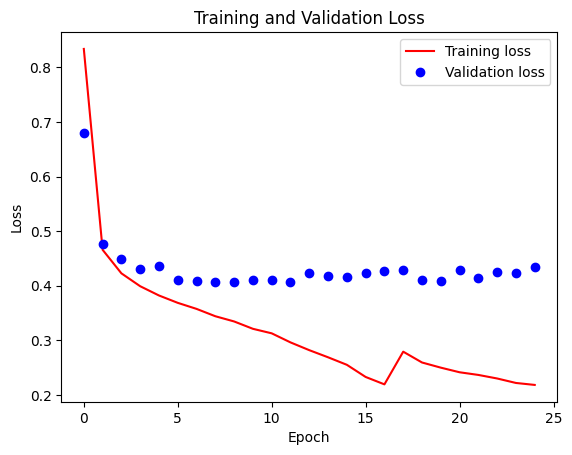

In [19]:
loss = history_stage1.history['loss'] + history_stage2.history['loss']
val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 13. FINAL PREDICTIONS


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


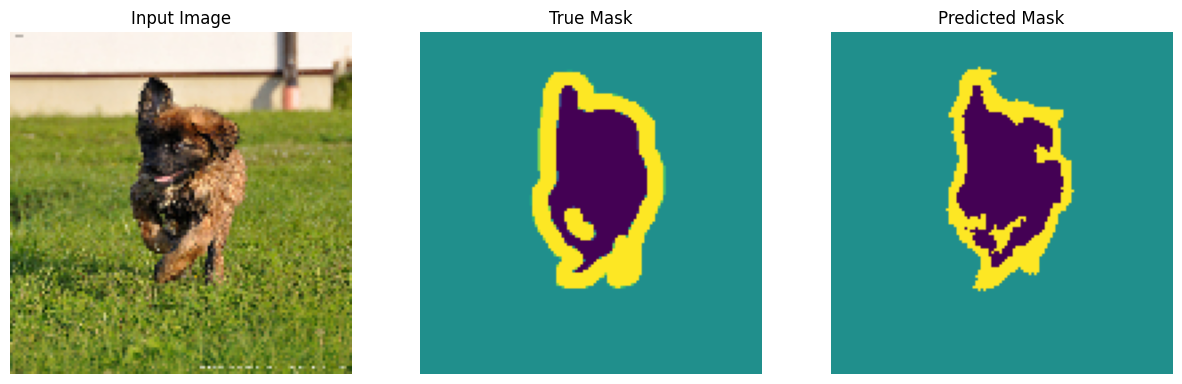

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


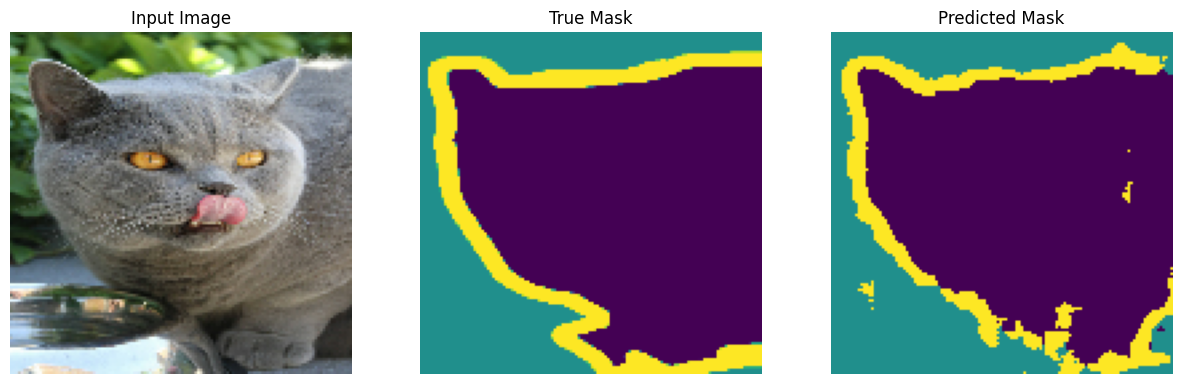

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


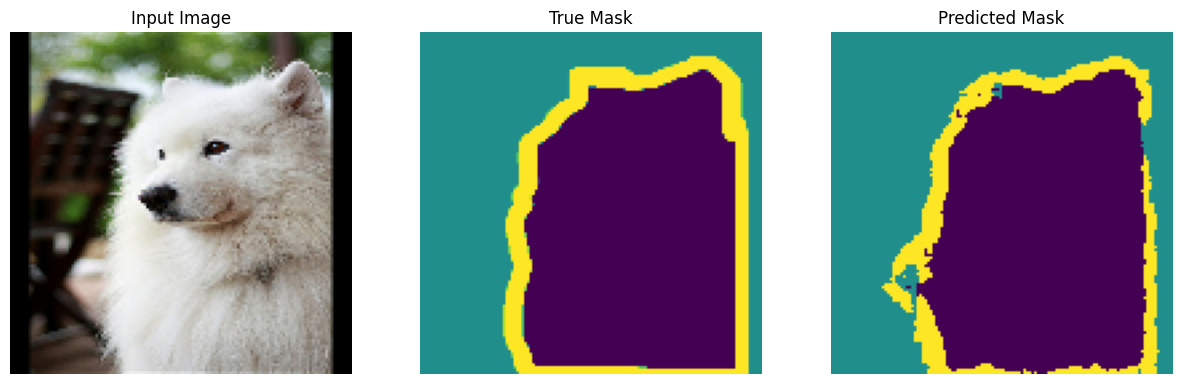

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


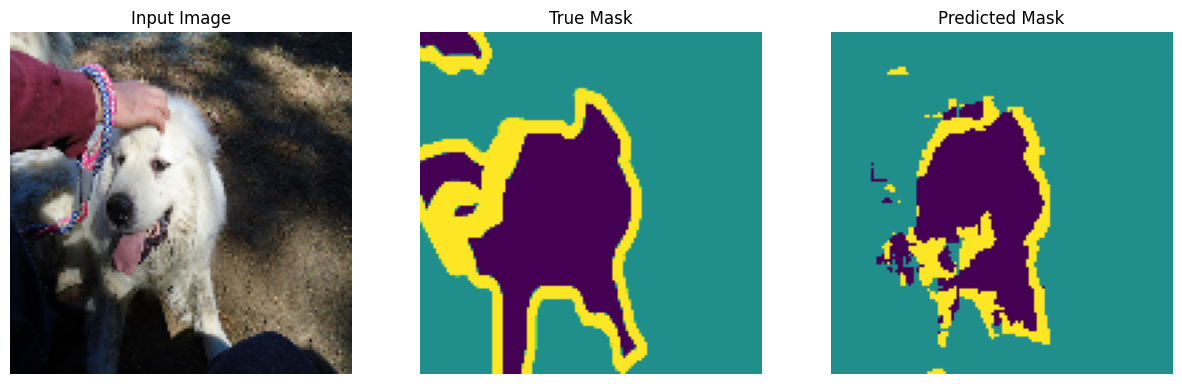

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


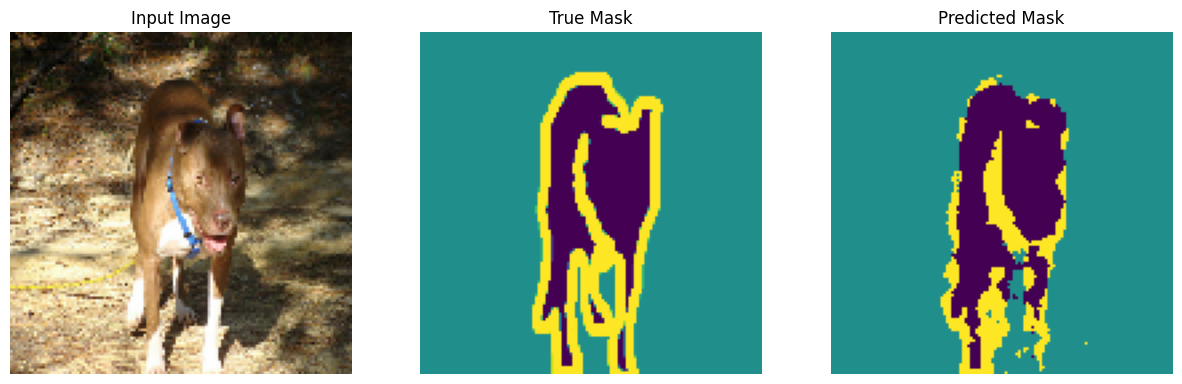

In [20]:
show_predictions(test_dataset, 5)